La Comisión de Taxis y Limusinas de la Ciudad de Nueva York (New York City TLC).

El objetivo de este proyecto es explorar los datos y ayudar a los taxistas a conseguir mayores ingresos. El planteamiento que llevamos a cabo fué crear un modelo de aprendizaje automático para predecir si un cliente dejará una propina generosa o no. 

Para ello se vana  crear dos modelos ( RF y XGBoost) para escoger el mejor clasificador para este problema y permita a los taxistas seleccionar los clientes que probablemente no dejarán propina, ya que los conductores dependen de las propinas.

In [181]:
import numpy as np
import pandas as pd

In [182]:
# Dataframe con todos los datos
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Dataframe con las predicciones de los modelos de
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [183]:
print(df0.head())
print(nyc_preds_means.head())   

   Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0    24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM   
1    35634249         1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM   
2   106203690         1   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM   
3    38942136         2   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM   
4    30841670         2  04/15/2017 11:32:20 PM  04/15/2017 11:49:03 PM   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                1           4.37           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0 

Union de los datasets mediante merge

In [184]:
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,...,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,...,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,...,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,...,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,...,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


## Ingenieria de características

En el proceso EDA ya observamos que los clientes que pagan con efectivo no dan propina en general. Para realizar un estudio de que clientes dan más propina debemos trabajar solo con aquellos que pagan con tarjeta.

In [185]:
df1 = df0[df0['payment_type']==1].copy() # Solo pagos en efectivo
df1 = df1.drop(columns=['payment_type'])

In [186]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351


Creamos la variable porcentaje de propina, ya que es sobre esta medida por la que vamos a clasificar a los clientes

In [187]:
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

A continuación generamos la variable objetivo, que define si un cliente va a ser generoso o no. Va a ser binaria. 0/1

In [188]:
# Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

# Variables de tiempo

Vamos a crear una variable día, para ello hay que transformar la variable numérica que ndica el momento de recogida  y de llegada al destino del cliente

In [189]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

También crearemos las variables horario. Serán 4 variables de tipo binario.

In [190]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

In [191]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val


In [192]:
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1["am_rush"].head

<bound method NDFrame.head of 0        1
1        0
2        1
3        0
5        0
        ..
22692    0
22693    0
22695    0
22697    0
22698    0
Name: am_rush, Length: 15265, dtype: int64>

In [193]:
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [194]:
df1['daytime'] = df1.apply(daytime, axis=1)
df1["daytime"].head

<bound method NDFrame.head of 0        0
1        1
2        0
3        1
5        0
        ..
22692    0
22693    0
22695    0
22697    1
22698    1
Name: daytime, Length: 15265, dtype: int64>

In [195]:
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [196]:
df1['pm_rush'] = df1.apply(pm_rush, axis=1)
df1["pm_rush"].head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
5        0
        ..
22692    0
22693    0
22695    1
22697    0
22698    0
Name: pm_rush, Length: 15265, dtype: int64>

In [197]:
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    else:
        val = 0
    return val


In [198]:
df1['nighttime'] = df1.apply(nighttime, axis=1)
df1["nighttime"].head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
5        1
        ..
22692    0
22693    1
22695    0
22697    0
22698    0
Name: nighttime, Length: 15265, dtype: int64>

Columna mes

In [199]:
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [200]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,...,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


# Selección de columnas imortantes.

In [201]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  fare_amount            15265 non-null  float64       
 11  extra                  15265 non-null  float64       
 12  mta_tax                15265 non-null  float64       
 13  tip_am

In [205]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
             'trip_distance', 'store_and_fwd_flag','fare_amount', 'extra',
             'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


Para ser introducidas al entrenamiento del modelo necesitamos variables numéricas, por lo que deberemos codificar las variables categóricas a variables Dummie. 

In [206]:
# Eliminar 'RatecodeID' de cols_to_dummie como si huviese sido eliminado antes
cols_to_dummie = ['PULocationID', 'DOLocationID', 'VendorID']

# Comprobar que las columnas existen en el DataFrame antes de convertir a string
for col in cols_to_dummie:
    if col in df1.columns:
        df1[col] = df1[col].astype(str)
    

In [207]:
df2 = pd.get_dummies(df1,drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 343 entries, passenger_count to month_sep
dtypes: bool(333), float64(3), int64(7)
memory usage: 6.1 MB


In [208]:
df1.head()

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,mean_duration,mean_distance,predicted_fare,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,2,6,1,100,231,22.847222,3.521667,16.434245,1,saturday,1,0,0,0,mar
1,1,1,1,186,43,24.470370,3.108889,16.052218,1,tuesday,0,1,0,0,apr
2,1,1,1,262,236,7.250000,0.881429,7.053706,0,friday,1,0,0,0,dec
3,2,1,1,188,97,30.250000,3.700000,18.731650,1,sunday,0,1,0,0,may
5,2,6,1,161,236,11.855376,2.052258,10.441351,1,saturday,0,0,0,1,mar


Vamos a escoger la métrica de evaluación. Para ello primero vamosm a explorar la variable objetivo. Para escoger la tolerancia al error hay que valorar cuales son las consecuencias en caso de los dos tipos ded error.

In [209]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

Dataset balanceado

Tipos de Error:
  * Falso positivo: El modelo prevee que el cliente va a ser generoso y no lo sea.
  * Falso negativo: El modelo prevee que el cliente no va a ser generoso y si lo es.

Un falso positivo es peor para el conductor, mientras que un falso negatico es peor para los clientes, ya que habrá casos en los que el conductor no querrá recogerles.

Hay que tener cuidado a la hora de ajustar el modelo, si nos decantamos mucho hacia el lado de los conductores habrá mucho cliente descontento.

## Construcción del modelo

In [210]:
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

Preparar los conjuntos de entrenamiento y test


In [211]:
y = df2['generous']
X = df2.drop('generous', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Vamos a realizar búsqueda de hiperparámetros para encontrar la mejor combinación de estos. GridSearchCV

In [212]:
rf = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [213]:
%%time
rf1.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
import pickle 

# Define a path to the folder where you want to save the model
path = r'C:\Users\alvar\Desktop\EDA\Automatidata\Github_taxis_nyc'
modelo = "rf1"

Vamos a guardar los pesos del modelo para poder recuperarlo más adelante sin tener que volver a entrenarlo.

In [ ]:
import os
import pickle

def write_pickle(path, model_object, save_name: str):
    file_path = os.path.join(path, save_name + '.pickle')
    with open(file_path, 'wb') as to_write:
        pickle.dump(model_object, to_write)
    print(f"✅ Archivo guardado en: {file_path}")


In [ ]:
path = r'C:\Users\alvar\Desktop\EDA\Automatidata\Github_taxis_nyc'
write_pickle(path, modelo, "RandomForest")


✅ Archivo guardado en: C:\Users\alvar\Desktop\EDA\Automatidata\Github_taxis_nyc\RandomForest.pickle


In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

Guardamos las mejores métricas para compararla con las de otros modelos.

In [ ]:
# Examine best score
rf1.best_score_

np.float64(0.7134553292229869)

Devuelve un df con las puntuaciones F1, recuperación, precisión y exactitud
    para el modelo con la mejor puntuación media «metric» en todos los pliegues de validación.

In [ ]:
def make_results(model_name:str, model_object, metric:str):

    # Crear un diccionario que asigne la métrica de entrada al nombre real de la métrica en GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    cv_results = pd.DataFrame(model_object.cv_results_)

    # Aislar la fila con la puntuación máxima (métrica)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extraer precisión, recuperación, f1 y exactitud de esa fila
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [ ]:
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.675659,0.756067,0.713455,0.68056


La ventaja de utilizar varios modelos para realizar predicciones sobre los datos de prueba es que se pueden comparar modelos utilizando datos que no se han utilizado para entrenar/ajustar los hiperparámetros. Esto reduce el riesgo de seleccionar un modelo basándose en lo bien que se ajusta a los datos de entrenamiento.

La desventaja de utilizar los datos de prueba finales para seleccionar un modelo es que, al utilizar datos desconocidos para decidir qué modelo utilizar, ya no se tiene una idea verdaderamente imparcial del rendimiento que se esperaría del modelo con datos nuevos. En este caso, considere la selección del modelo final como otra forma de «ajustar» su modelo.

In [ ]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

Con esta función se guardan las métricas de las predicciones

In [ ]:
def get_test_scores(model_name:str, preds, y_test_data):
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [ ]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.675659,0.756067,0.713455,0.680560
0,RF test,0.673889,0.774113,0.720533,0.683917


##### **XGBoost**

Se crea el modelo XGBoost empleando cross validation con nuevos parámetros y al igual que con el modelo anterior guardar las métricas de evaluación.

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'learning_rate': [0.1, 0.05, 0.01],
             'max_depth': [8, 6, 4],
             'min_child_weight': [2, 3, 1],
             'n_estimators': [500, 300, 100]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [ ]:
%%time
xgb1.fit(X_train, y_train)

CPU times: total: 1h 15min 1s
Wall time: 5min 40s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.05, ...], 'max_depth': [8, 6, ...], 'min_child_weight': [2, 3, ...], 'n_estimators': [500, 300, ...]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'f1'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


Mejor métrica de evaluación

In [ ]:
modelo = "xgb1"

In [ ]:
write_pickle(path, modelo, "XGBoost")

✅ Archivo guardado en: C:\Users\alvar\Desktop\EDA\Automatidata\Github_taxis_nyc\XGBoost.pickle


In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [ ]:
xgb1.best_score_

np.float64(0.7479383895632495)

Parámetros del mejor modelo después de la búsqueda de hiperparámetros

In [ ]:
xgb1.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 100}

Métricas del modelo con los datos de entrenamiento

In [ ]:
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.675659,0.756067,0.713455,0.680560
0,RF test,0.673889,0.774113,0.720533,0.683917
0,XGB CV,0.693290,0.812072,0.747938,0.711923


Cálculo de las métricas con los datos del conjunto de test.

In [ ]:
xgb_preds = xgb1.best_estimator_.predict(X_test)
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.675659,0.756067,0.713455,0.680560
0,RF test,0.673889,0.774113,0.720533,0.683917
0,XGB CV,0.693290,0.812072,0.747938,0.711923
0,XGB test,0.684982,0.814561,0.744173,0.705208


Tras observar las métricas para ambos modelos encontramos que XGB realiza mejores predicciones y será el escogido.

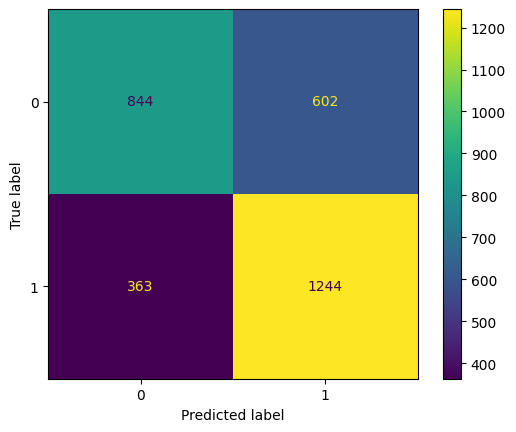

In [ ]:
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(values_format='');

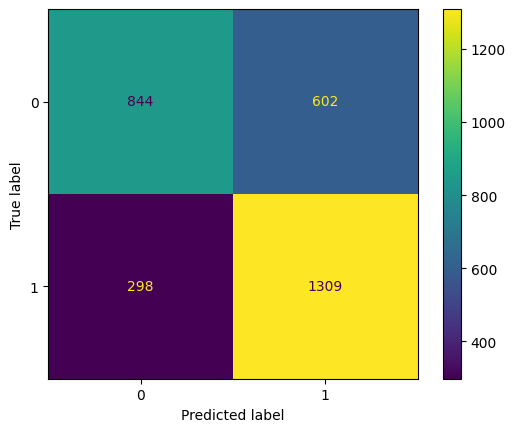

In [ ]:
cm = confusion_matrix(y_test, xgb_preds, labels=xgb1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb1.classes_, 
                             )
disp.plot(values_format='');

El modelo tiene casi el doble de probabilidades de predecir un falso positivo que de predecir un falso negativo. Por lo tanto, los errores de tipo I son más comunes. Esto es menos deseable, porque es mejor que un conductor se lleve una agradable sorpresa con una propina generosa cuando no la esperaba que se sienta decepcionado por una propina baja cuando esperaba una generosa. Sin embargo, el rendimiento general de este modelo es satisfactorio. 

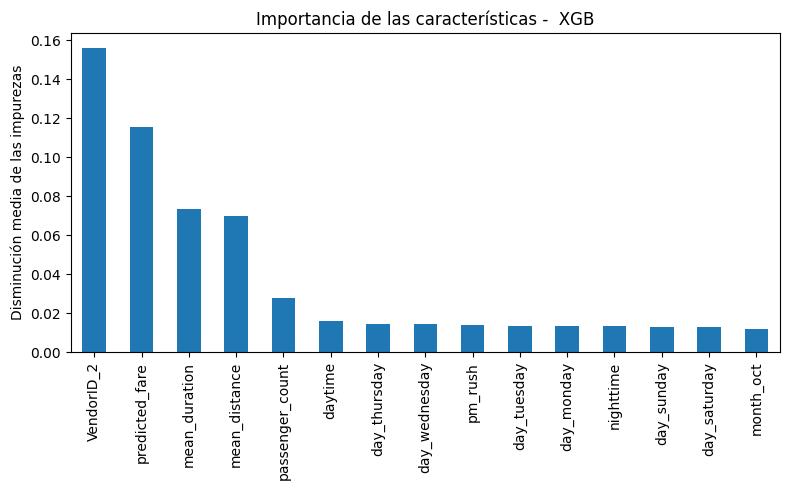

In [ ]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Importancia de las características -  XGB')
ax.set_ylabel('Disminución media de las impurezas')
fig.tight_layout();

Probablemente sería muy útil disponer del historial de propinas de cada cliente. También sería valioso disponer de valores precisos de las propinas de los clientes que pagan en efectivo.
Sería útil disponer de muchos más datos. Con datos suficientes, podríamos crear una característica única para cada combinación de recogida/entrega.


Recuerde que, a veces, sus datos simplemente no serán predictivos del objetivo elegido. Esto es habitual. El aprendizaje automático es una herramienta poderosa, pero no es mágica. Si sus datos no contienen señales predictivas, ni siquiera el algoritmo más complejo podrá ofrecer predicciones coherentes y precisas. No tema llegar a esta conclusión. Aunque no pueda utilizar el modelo para hacer predicciones sólidas, ¿el trabajo realizado ha sido en vano? ¿Qué información puede comunicar a las partes interesadas?